## Updated SVM/Modifications

In [6]:
#Step 1: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.inspection import permutation_importance

In [7]:
#Step 2: Load Dataset
data_path = "student_health_data.csv"
student_health_data = pd.read_csv(data_path)

# Drop irrelevant columns
student_health_data = student_health_data.drop(columns=["Student_ID"], errors='ignore')

In [8]:
#Step 3: Encode Categorical Variables
label_encoder = LabelEncoder()
categorical_columns = ["Gender", "Physical_Activity", "Sleep_Quality", "Mood", "Health_Risk_Level"]
for col in categorical_columns:
    student_health_data[col] = label_encoder.fit_transform(student_health_data[col])

In [9]:
#Step 4: Separate Features and Target Variable
X = student_health_data.drop(columns=["Health_Risk_Level"])
y = student_health_data["Health_Risk_Level"]

In [10]:
#Step 5: Split Data into Train, Validation, and Test Sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [11]:
#Step 6: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [14]:
#Step 7: Optimized SVM Model (Hyperparameter Tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

grid_search_svm = GridSearchCV(SVC(probability=True, random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)

#Get Best SVM Model
best_svm = grid_search_svm.best_estimator_

#Make Predictions
y_train_pred = best_svm.predict(X_train)
y_val_pred = best_svm.predict(X_val)
y_test_pred = best_svm.predict(X_test)

#Compute Accuracy & F1 Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='weighted')
val_f1 = f1_score(y_val, y_val_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

#Print Results
print("\n🔹 **Optimized SVM Model Accuracy & F1 Scores:**")
print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"Train Accuracy: {train_accuracy:.4f} | F1 Score: {train_f1:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f} | F1 Score: {val_f1:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} | F1 Score: {test_f1:.4f}")

print("\nValidation Classification Report:")
print(classification_report(y_val, y_val_pred))

print("\nTest Classification Report:")
print(classification_report(y_test, y_test_pred))


🔹 **Optimized SVM Model Accuracy & F1 Scores:**
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Train Accuracy: 1.0000 | F1 Score: 1.0000
Validation Accuracy: 0.8600 | F1 Score: 0.8547
Test Accuracy: 0.8850 | F1 Score: 0.8838

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.54      0.61        28
           1       0.89      0.84      0.86        38
           2       0.87      0.93      0.90       134

    accuracy                           0.86       200
   macro avg       0.83      0.77      0.79       200
weighted avg       0.85      0.86      0.85       200


Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.70      0.73        27
           1       0.91      0.84      0.88        38
           2       0.90      0.93      0.92       135

    accuracy                           0.89       200
   macro avg       0.86      0.83      0.8

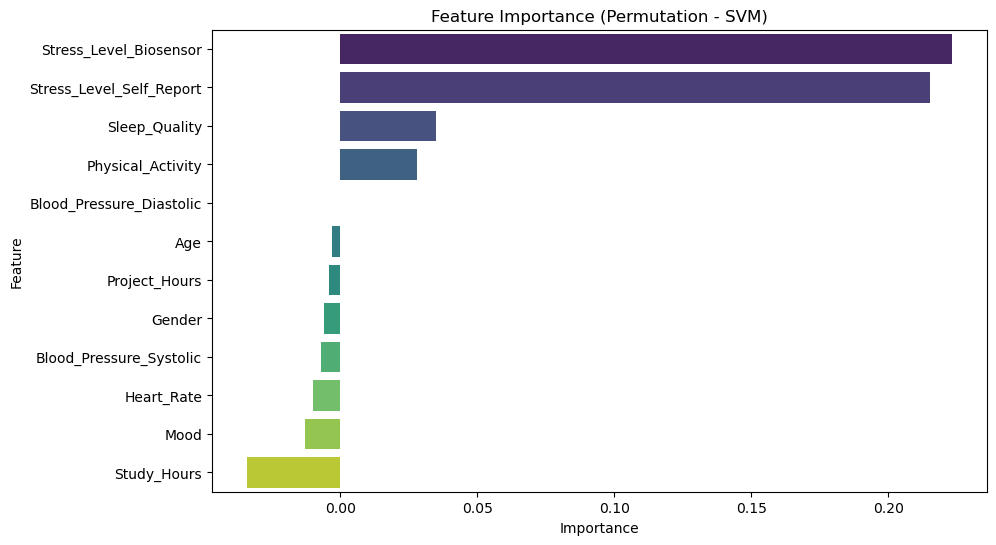

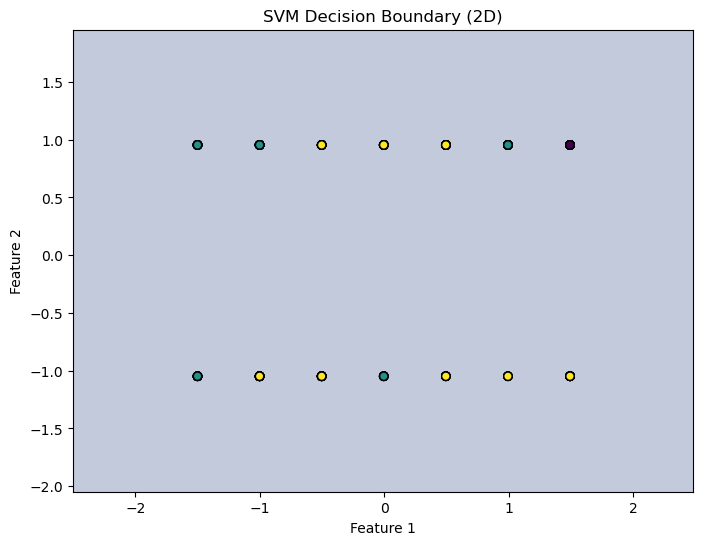

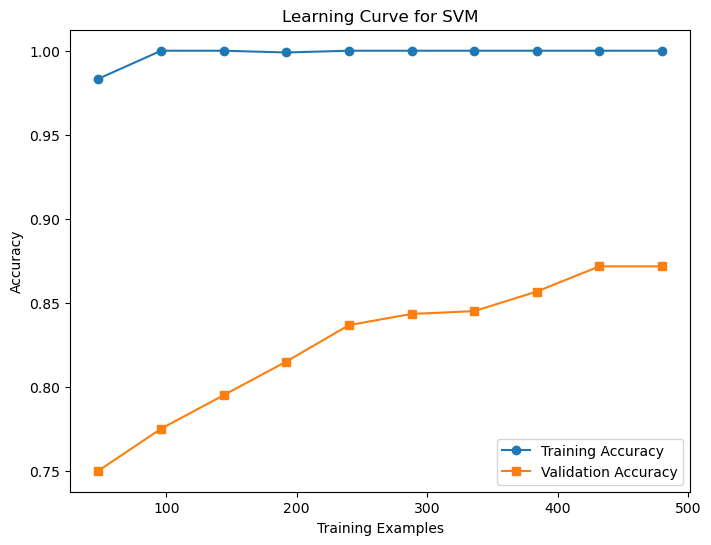

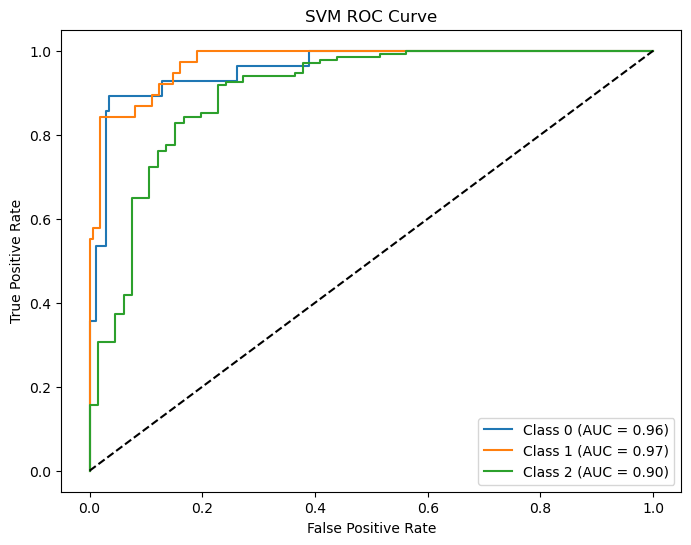

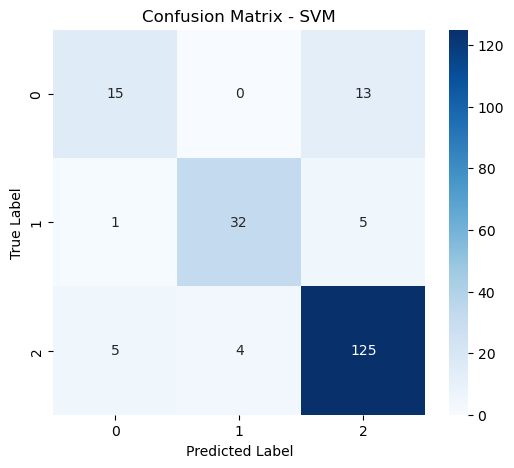

In [15]:
#Step 8: Visualizations

##Feature Importance (Permutation Importance)
perm_importance = permutation_importance(best_svm, X_val, y_val, scoring='accuracy')
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': perm_importance.importances_mean})
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance_df['Importance'], y=importance_df['Feature'], palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation - SVM)")
plt.show()

##Decision Boundary Plot (Custom Implementation)
def plot_decision_boundary(X, y, model):
    h = 0.02  # Step size for mesh grid

    #Select two features for plotting
    X_plot = X[:, [0, 1]]
    x_min, x_max = X_plot[:, 0].min() - 1, X_plot[:, 0].max() + 1
    y_min, y_max = X_plot[:, 1].min() - 1, X_plot[:, 1].max() + 1

    #Create mesh grid
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    #Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_plot[:, 0], X_plot[:, 1], c=y, edgecolors='k', marker='o')
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("SVM Decision Boundary (2D)")
    plt.show()

#Train SVM on two features and plot
svm_2D = SVC(kernel="rbf", C=10, gamma="scale")
svm_2D.fit(X_train[:, [0, 1]], y_train)
plot_decision_boundary(X_val, y_val, svm_2D)

##Learning Curve
train_sizes, train_scores, val_scores = learning_curve(
    best_svm, X_train, y_train, cv=5, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 10))

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, "o-", label="Training Accuracy")
plt.plot(train_sizes, val_mean, "s-", label="Validation Accuracy")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")
plt.title("Learning Curve for SVM")
plt.legend()
plt.show()

##ROC Curve
y_val_bin = label_binarize(y_val, classes=np.unique(y_val))
y_scores = best_svm.decision_function(X_val)

plt.figure(figsize=(8, 6))
for i in range(y_val_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_scores[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("SVM ROC Curve")
plt.legend()
plt.show()

##Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_val, y_val_pred), annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - SVM")
plt.show()

### Accuracy Analysis

Train Accuracy: 100%
* The model performed perfectly on the training set, meaning it was able to classify every training example correctly.
* This suggests that the model has learned patterns well, but need to check if it overfits.

Validation Accuracy: 86%
* The model correctly classified 86% of validation samples.
* This is a strong score and suggests good generalization to unseen data.

Test Accuracy: 89%
* On new, unseen test data, the model performed even better (89%).
This suggests that the model did not overfit but instead generalized well.

### F1-Score Analysis

Metric	Validation Set	Test Set
F1-Score	0.85 (85%)	0.88 (88%)

* The F1-score is important because it considers both precision and recall.
* The scores indicate that the model balances correctly identifying positives and avoiding false positives.
* Test F1 (88%) is slightly better than Validation F1 (85%), meaning the model works even better when making real-world predictions.

F1-score close to accuracy suggests balanced precision and recall. If F1-score was much lower than accuracy, the model would be favoring one class too much (bias).

### Feature Importance (Permutation Importance)

* This graph ranks features based on their contribution to SVM predictions.
* The most important features contribute the most to the decision-making process.
* If some features have very low importance, they might be removed to simplify the model.

### Decision Boundary Plot

* The SVM decision boundary separates different classes in two-dimensional space.
* It creates smooth regions where the model classifies data points.
* If the boundary is too complex, the model might be overfitting.
* If it's too simple, the model might be underfitting.

### Learning Curve

* This shows how accuracy improves as training data increases.
* If the training and validation curves converge, the model is well-trained.
* If there's a big gap, it suggests overfitting or underfitting.

### ROC Curve (Confidence in Predictions)

* The ROC curve measures how well SVM differentiates between classes.
* AUC (Area Under Curve) close to 1 means the model is very confident.
* If AUC is around 0.5, the model is randomly guessing.
* Higher AUC means better classification performance and if AUC is below 0.7, the model may need better features or hyperparameter tuning.

### Confusion Matrix Analysis

* The confusion matrix shows how many times the model correctly and incorrectly classified each class.
* The diagonal (blue squares) shows correct classifications.
* Off-diagonal values show misclassifications.

## Old SVM Coding

In [3]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


Training Performance:
              precision    recall  f1-score   support

           0       0.78      0.54      0.64        83
           1       0.91      0.83      0.87       114
           2       0.87      0.95      0.91       403

    accuracy                           0.87       600
   macro avg       0.85      0.78      0.81       600
weighted avg       0.87      0.87      0.87       600


Validation Performance:
              precision    recall  f1-score   support

           0       0.81      0.46      0.59        28
           1       0.84      0.82      0.83        38
           2       0.85      0.93      0.89       134

    accuracy                           0.84       200
   macro avg       0.83      0.74      0.77       200
weighted avg       0.84      0.84      0.84       200


Test Performance:
              precision    recall  f1-score   support

           0       0.72      0.48      0.58        27
           1       0.84      0.68      0.75        38
        

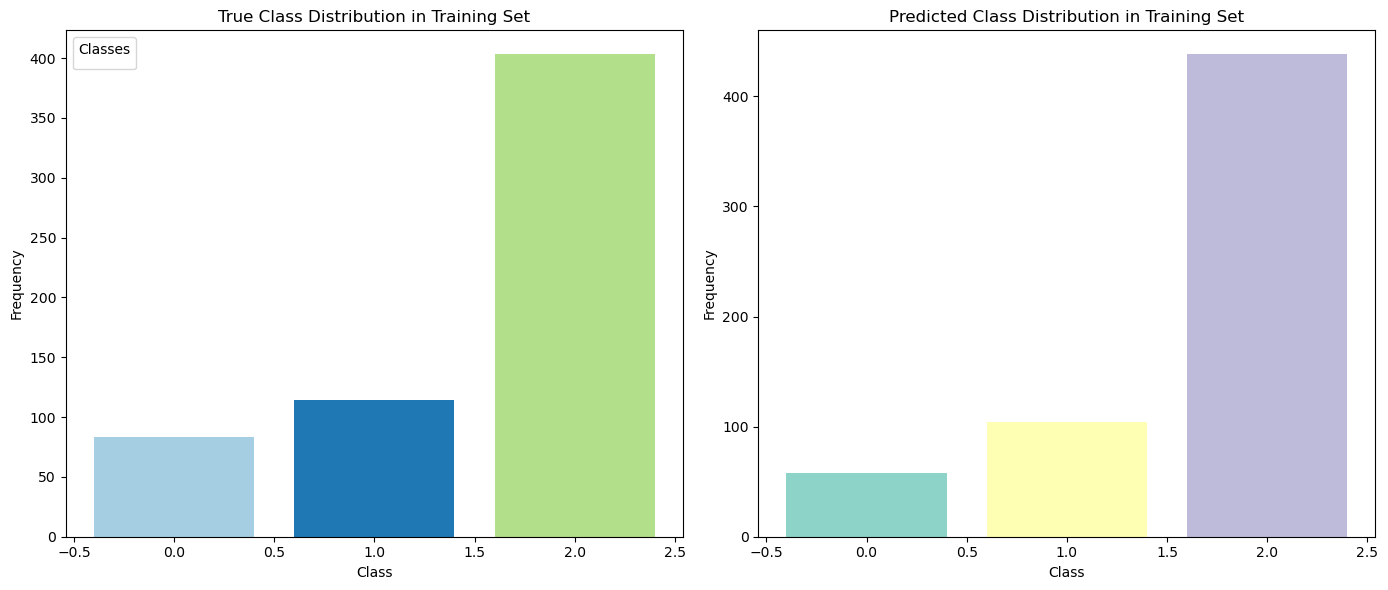

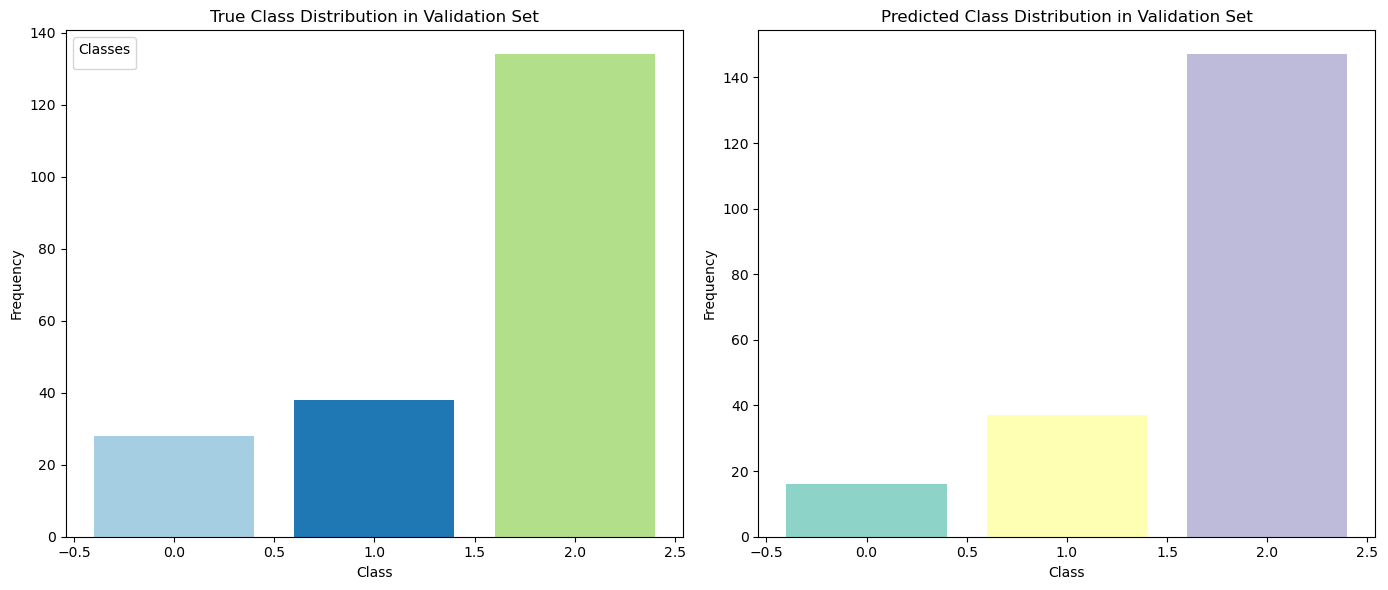

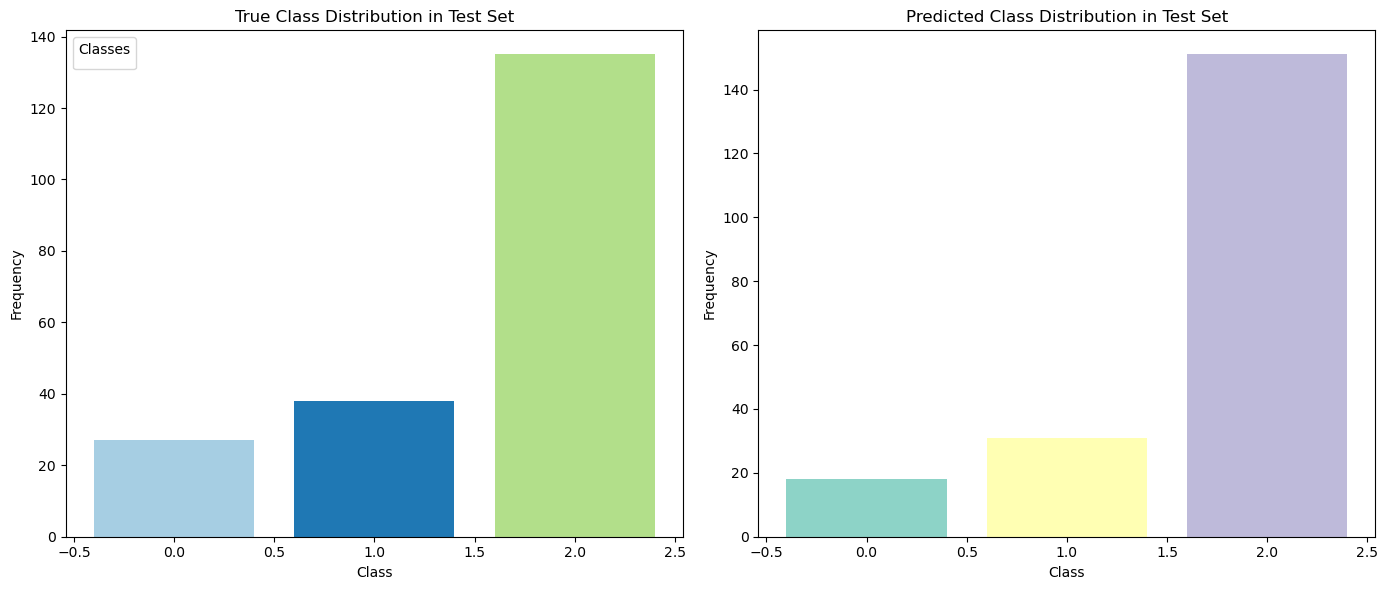

In [4]:
# Load the uploaded dataset
data_path = "student_health_data.csv"  # The uploaded file name
student_health_data = pd.read_csv(data_path)

# Data preprocessing
# Drop the Student_ID column as it's not relevant
student_health_data = student_health_data.drop(columns=["Student_ID"])

# Encode categorical variables
label_encoder = LabelEncoder()
categorical_columns = ["Gender", "Physical_Activity", "Sleep_Quality", "Mood", "Health_Risk_Level"]
for col in categorical_columns:
    student_health_data[col] = label_encoder.fit_transform(student_health_data[col])

# Separate features and target variable
X = student_health_data.drop(columns=["Health_Risk_Level"])
y = student_health_data["Health_Risk_Level"]

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Scale the features for SVM
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Train an SVM model
svm_model = SVC(kernel="linear", probability=True, random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions
y_train_pred = svm_model.predict(X_train)
y_val_pred = svm_model.predict(X_val)
y_test_pred = svm_model.predict(X_test)

# Evaluation
print("\nTraining Performance:")
print(classification_report(y_train, y_train_pred))

print("\nValidation Performance:")
print(classification_report(y_val, y_val_pred))

print("\nTest Performance:")
print(classification_report(y_test, y_test_pred))

# Visualizing class distribution in predictions using matplotlib
def plot_class_distribution(y_true, y_pred, dataset_name):
    unique_classes = sorted(set(y_true))
    colors_true = plt.cm.Paired.colors[:len(unique_classes)]  # Unique colors for true classes
    colors_pred = plt.cm.Set3.colors[:len(unique_classes)]   # Unique colors for predicted classes

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    axes[0].legend(unique_classes, title="Classes")


    # Plot true class distribution with unique colors
    axes[0].bar(unique_classes, [list(y_true).count(c) for c in unique_classes], color=colors_true)
    axes[0].set_title(f"True Class Distribution in {dataset_name}")
    axes[0].set_xlabel("Class")
    axes[0].set_ylabel("Frequency")

    # Plot predicted class distribution with unique colors
    axes[1].bar(unique_classes, [list(y_pred).count(c) for c in unique_classes], color=colors_pred)
    axes[1].set_title(f"Predicted Class Distribution in {dataset_name}")
    axes[1].set_xlabel("Class")
    axes[1].set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


# Plot distributions for training, validation, and test sets
plot_class_distribution(y_train, y_train_pred, "Training Set")
plot_class_distribution(y_val, y_val_pred, "Validation Set")
plot_class_distribution(y_test, y_test_pred, "Test Set")
